## Required libraries

In [1]:
import os
import cv2
import glob
import torch
import datetime
import numpy as np
from PIL import Image
import torch.nn as nn
import albumentations as A
from torch import from_numpy
import torch.nn.functional as F
from torch.nn import DataParallel
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader

In [2]:
# Data path
INPUT_PATH = '../input/cityscapes-image-pairs/cityscapes_data'

## Parameters

In [3]:
INPUT_IMG_SIZE = 256

OUTPUT_CLASSES = 12

LEARINING_RATE = 0.01

OPIMIZER_NAME = 'Adam'
    
SCHEDULER_NAME = 'stepLR'

BATCH_SIZE = 8

MAX_EPOCHS = 10

AUGMENTATION = False 

# MEAN = (0.485, 0.456, 0.406)

# STD = (0.229, 0.224, 0.225)

# MEAN = (0.5,0.5,0.5) 

# STD = (0.5,0.5,0.5) 

MEAN = None

STD = None 

THRESH_ACC_CKP = 0.9

SCHEDULER_STEP_SIZE = 4

USE_CUDA = torch.cuda.is_available()

## Data preprocessing

In [4]:
train_files = glob.glob(os.path.join(INPUT_PATH + '/train', '*jpg'))
test_files = glob.glob(os.path.join(INPUT_PATH + '/val', '*jpg'))

print('Total train images:', len(train_files))
print('Total test images:', len(test_files))



Total train images: 2975
Total test images: 500


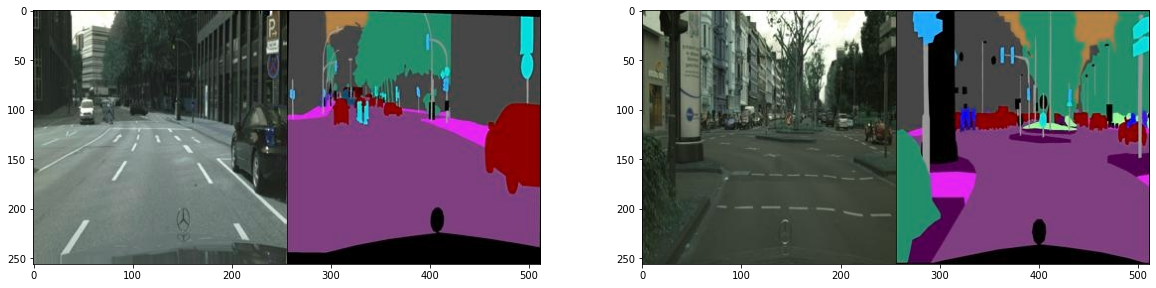

In [5]:
fig, axes = plt.subplots(1,2, figsize = (20,5))
for i, ax in enumerate(axes.ravel()):
    img = cv2.imread(train_files[i])
    ax.imshow(img)
    #ax.axis('off')
plt.show()

* #### As previously stated, the original image and its corresponding mask image are combined into a single image.
* #### We can cut these images into two halves (original image and mask)

----------------------------------------
Original image shape: (256, 256, 3)
Mask image shape: (256, 256, 3)
----------------------------------------


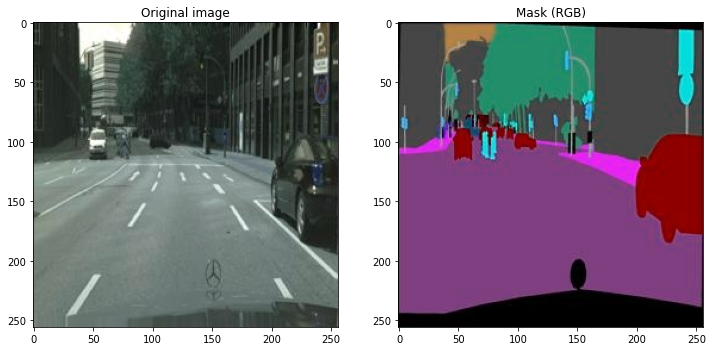

----------------------------------------
Original image shape: (256, 256, 3)
Mask image shape: (256, 256, 3)
----------------------------------------


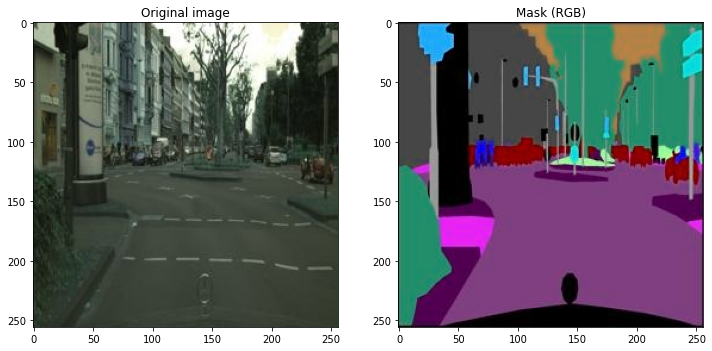

----------------------------------------
Original image shape: (256, 256, 3)
Mask image shape: (256, 256, 3)
----------------------------------------


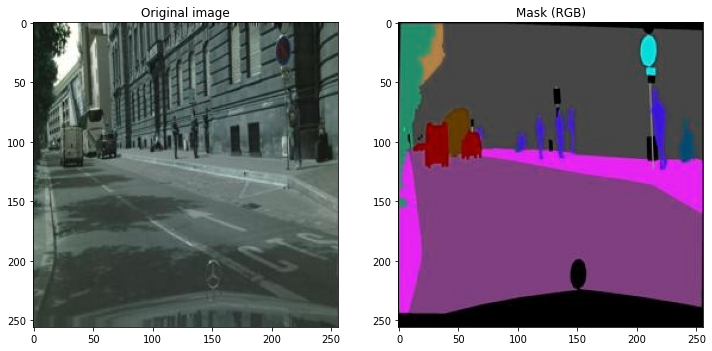

----------------------------------------
Original image shape: (256, 256, 3)
Mask image shape: (256, 256, 3)
----------------------------------------


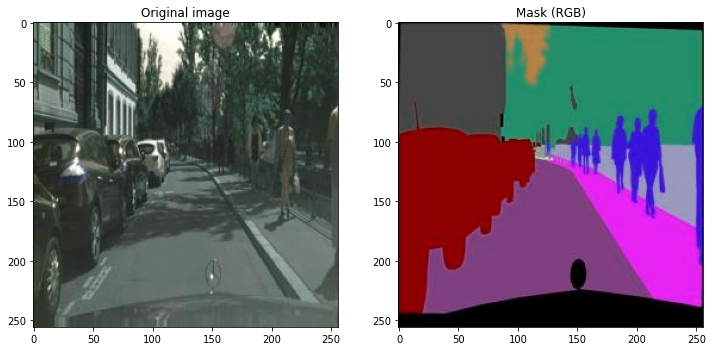

In [6]:
for i in train_files[:4]:
    org_img = cv2.imread(i)
    img = org_img[:, 0:256,:]
    msk = org_img[:, 256:,:]
    img = img/255
    
    print('-'*40)
    print('Original image shape:',img.shape)
    print('Mask image shape:',msk.shape)
    print('-'*40)
    
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Original image')
    plt.subplot(1,2,2)
    plt.imshow(msk)
    plt.title('Mask (RGB)')
    plt.show()
    

### As you can observe: 

*  Masks are in the RGB format 
*  The Number of segmented classes is changing in every mask (non uniform class number in the label data).
*  Masks are not encoded

### Preparation:

*  Using Kmeans algorithm --> clustering the unique colors present in a mask
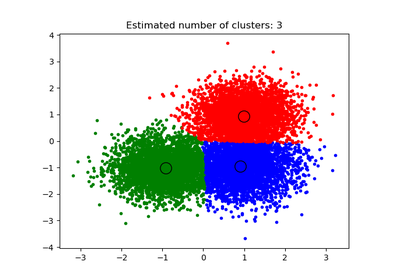

*  Use trained Kmeans to encode RGB mask as color encoded mask

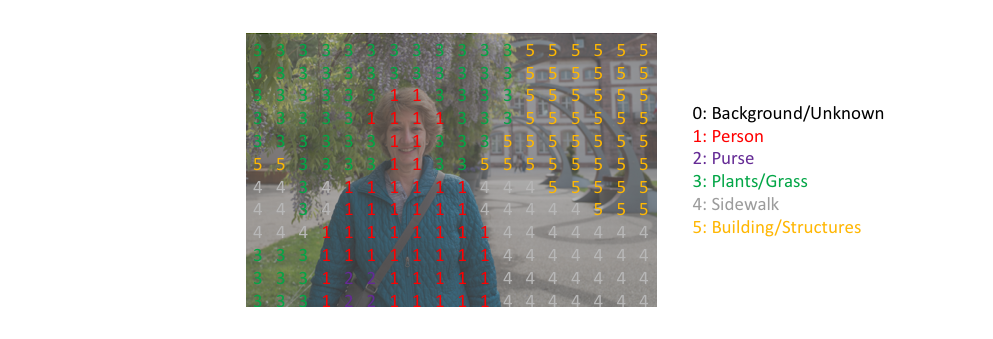

*  As illustated in the above example, every object in that image has been encoded with a specific number
*  I am also doing the same thing by using kmeans

## Mask encoding

* I am going to use 50 masks as training data for clustering
* (50, 256, 256, 3) --> (50 x 256 x 256, 3) --> (3276800, 3) 
* I have 3276800 data points (3 --> RGB values) for clustering
* Using 12 kmeans clutseres

In [7]:
kmeans_data = []
for i in train_files[:50]:
    org_img = cv2.imread(i)
    #img = org_img[:, 0:INPUT_IMG_SIZE,:]
    msk = org_img[:, INPUT_IMG_SIZE:,:]
    kmeans_data.append(msk)
kmeans_data = np.array(kmeans_data)
kmeans_data = kmeans_data.reshape(-1,3)
print(kmeans_data.shape)

(3276800, 3)


In [8]:
# train kmeans with 10 clusters
encoder = KMeans(n_clusters=OUTPUT_CLASSES)
encoder.fit(kmeans_data)

KMeans(n_clusters=12)

In [9]:
colors = {0: [255,0,0],
          1: [0,255,0],
          2: [0,0,255],
          3: [255,69,0],
          4: [255,0,255],
          5: [210,105,30],
          6: [192,255,62],
          7: [127,255,0],
          8: [0,238,238],
          9: [72,118,255],
          10: [72,255,255],
          11: [255,118,255]
          }

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


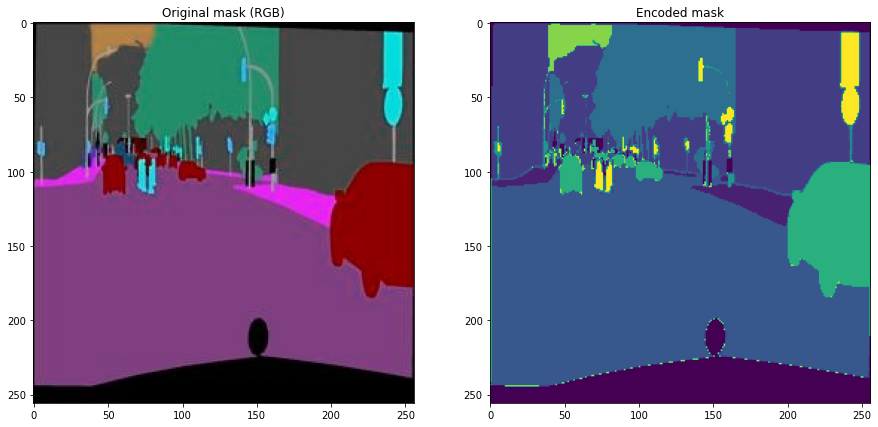

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


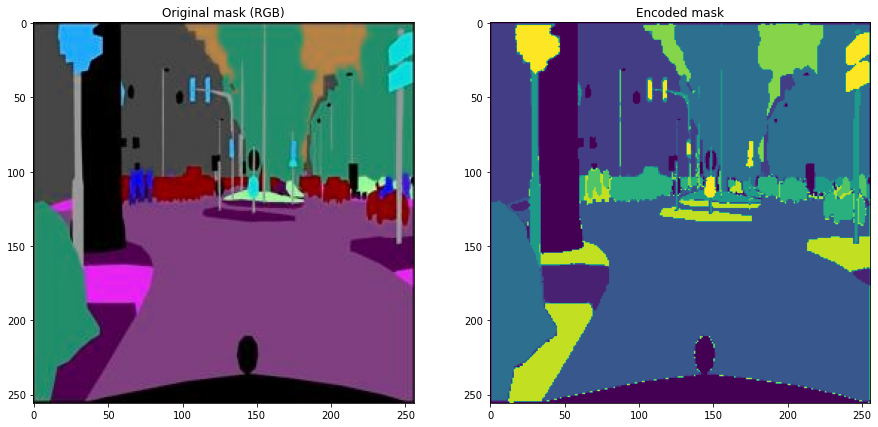

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


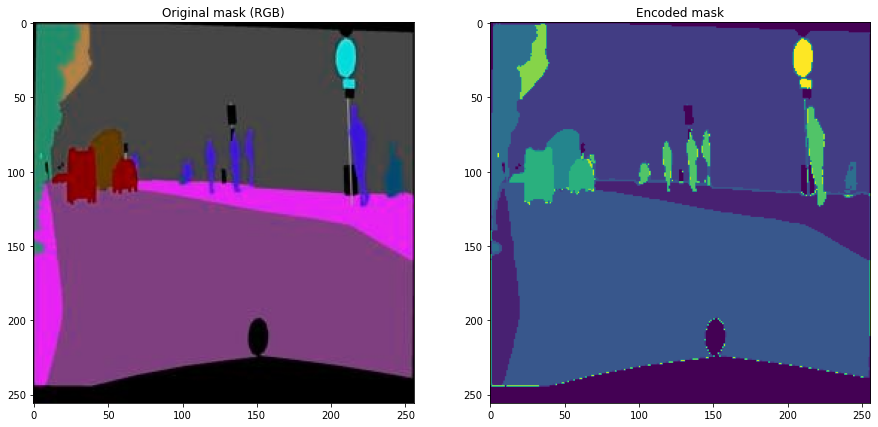

In [10]:
# encoding with trained kmeans
for i in train_files[:3]:
    org_img = cv2.imread(i)
    #img = org_img[:, 0:256,:]
    msk = org_img[:, 256:,:]      #shape (256,256,3)
    test = msk.reshape(-1,3)      #shape (65536,3)
    pred = encoder.predict(test)  #shape (65536)
    
    enc_pred = pred.reshape(INPUT_IMG_SIZE,INPUT_IMG_SIZE)  #shape (256,256)
    
    pred = np.array([colors[p] for p in pred]).reshape(256,256,3)
    
    print('No of classes in encoded mask:',np.unique(enc_pred))
    
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(msk)
    plt.title('Original mask (RGB)')
    plt.subplot(1,2,2)
    plt.imshow(enc_pred)
    plt.title('Encoded mask')
    plt.show()

## Load dataset

In [11]:
class Dataset(Dataset):
    def __init__(self, images_list, size, augmentation = False, mean = None, std = None):
        self.images_list = images_list
        self.size = size
        self.augmentation = augmentation
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std
        
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        pil_image = Image.open(self.images_list[index]).convert('RGB')
        org_img = np.array(pil_image)
        
        np_image = org_img[:, 0:256,:]
        np_target = org_img[:, 256:,:] 
        
        test = (np_target.reshape(-1,3))      
        pred = encoder.predict(test)
        seg_msk = pred.reshape(256,256)
        
        if self.augmentation:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                           #A.OneOf([A.ToSepia()], p=0), 
                           A.Rotate(10, border_mode=4, p=0.5),
                           A.HorizontalFlip(p=0.3),
                           A.VerticalFlip(p=0.3),
                           #GridDistortion(num_steps=100,distort_limit=0.3,p=1),
                           #InvertImg(p=0.4),
                           #A.CLAHE(clip_limit=4, p=0),
                           A.OneOf([A.OpticalDistortion(),A.ElasticTransform()],  p=0.4),  
                           #A.OneOf([A.GaussNoise(), A.GaussianBlur()], p=0),
                           A.CoarseDropout(max_holes=30, max_height=int(self.size*0.015),
                                         max_width=int(self.size*0.015), fill_value=255, p=0.4),
                           A.RandomBrightnessContrast(brightness_limit=0.3,p = 0.4),
                           A.RandomSnow(snow_point_lower=0.4,snow_point_upper=0.5,brightness_coeff=1.5,p = 0.4),
                           #RandomGamma(gamma_limit=(200,200),p = 1),
                           #A.RGBShift(p = 0),
                           A.Normalize(self.mean, self.std)
                          ])
        else:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])
            
        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor
    

## Model-1: Unet

In [12]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

## Model-2: Tunable Unet

In [13]:
class UNetTunable(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
        conv_mode='standard'
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        
        super(UNetTunable, self).__init__()
        assert conv_mode in ('standard', 'dilated')
        assert up_mode in ('upconv', 'upsample', 'dilated')
        
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm,conv_mode)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm,conv_mode)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm,conv_mode):
        super(UNetConvBlock, self).__init__()
        
        if conv_mode == 'standard':
            block = []
            block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            self.block = nn.Sequential(*block)
            
        elif conv_mode == 'dilated':
            block = []
            block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding), dilation = 1 ))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding), dilation = 1 ))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm, conv_mode):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )
        elif up_mode == 'dilated':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm, conv_mode)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

## Trainer

In [14]:
class Trainer:
    def __init__(self,               
                 model,                          # Model to be trained.
                 crit,                           # Loss function
                 train_data = None,              # Training data set
                 val_data = None,                # Validation (or test) data set
                 initialize_from_ckp = None,     # If you want to continue training from a specific checkpoint
                 opti_name = None,
                 scheduler_name = None,
                 input_img_size = None,
                 batch_size = None,
                 out_classes = None,
                 use_cuda = False,
                 max_epochs = None,
                 learning_rate = None,
                 thresh_acc = None,
                 experiment_name = None,
                 step_size = None
                 ):
        self.model = model
        self.crit = crit
        self.train_data = train_data
        self.val_data = val_data
        self.opti_name = opti_name
        self.scheduler_name = scheduler_name
        self.input_img_size = input_img_size
        self.batch_size = batch_size
        self.out_classes = out_classes
        self.cuda = use_cuda
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.thresh_acc_ckp = thresh_acc
        self.step_size = step_size
        
        if use_cuda:
            self.model = model.cuda()
            self.crit = crit.cuda()
            self.model = DataParallel(model)
            
        self.optim = self.select_optimizer()
        self.scheduler = self.select_scheduler()
        self.train_dl = self.data_loader(self.train_data)
        self.val_test_dl = self.data_loader(self.val_data)
        self.nowtime = datetime.datetime.now().strftime('%d-%m-%Y [%H.%M.%S]')
        
        if initialize_from_ckp is not None:
            self.restore_checkpoint(initialize_from_ckp)
        
    def data_loader(self, data_object):
        return DataLoader(data_object, batch_size = self.batch_size, shuffle=True)
    
    def select_optimizer(self):
        if self.opti_name == 'Adam':
            return Adam(self.model.parameters(), lr=self.learning_rate)
        if self.opti_name == 'SGD':
            return SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)
        
    def select_scheduler(self):
        if self.scheduler_name == 'stepLR':
            return lr_scheduler.StepLR(optimizer=self.optim, step_size = self.step_size, gamma=0.1)
        if self.scheduler_name == 'ReduceLROnPlateau':
            return lr_scheduler.ReduceLROnPlateau(optimizer = self.optim, mode='max', factor=0.2)
            
    def restore_checkpoint(self, checkpoint):
        cuda_device = torch.device('cuda' if self.cuda else 'cpu')
        ckp = torch.load(checkpoint, map_location = cuda_device)
        self.model.load_state_dict(ckp)
        for param in self.model.features.parameters():
            param.requires_grad = False
        # self._optim.load_state_dict(ckp)
    
    def save_checkpoint(self, folder_name):
        torch.save({'state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optim.state_dict(),
                }, folder_name + '/checkpoint.ckp')
    
    def IoU(self, label, pred, num_classes=12):
        label = label.detach().cpu()
        pred = pred.detach().cpu()
        
        pred = F.softmax(pred, dim=1)              
        pred = torch.argmax(pred, dim=1).squeeze(1)
        iou_list = list()
        present_iou_list = list()
        
        pred = pred.view(-1)
        label = label.view(-1)
        # Note: Following for loop goes from 0 to (num_classes-1)
        # and ignore_index is num_classes, thus ignore_index is
        # not considered in computation of IoU.
        for sem_class in range(num_classes):
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else: 
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
        return np.mean(present_iou_list)
        
    def train_epoch(self):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.train()
        loss_list = []
        acc_list = []
        for i, (images, labels) in enumerate(self.train_dl):
            batchsize = images.shape[0]
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            self.optim.zero_grad()
            preds = self.model(images)
            loss = self.crit(preds, labels.long())
            accuracy = self.IoU(labels, preds) 
            #print(accuracy)
            loss.backward()
            self.optim.step()
            lossitem = loss.item() 
            del loss  # this may be the fix for my OOM error
            loss_list.append(lossitem)
            acc_list.append(accuracy)
        
        loss_avg = np.mean(loss_list) 
        acc_avg = np.mean(acc_list) 
        return loss_avg, acc_avg
    
    def val_epoch(self, current_epoch):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.eval()
        loss_list = []
        acc_list = []
        with torch.no_grad():
            for i, (images, labels) in enumerate(self.val_test_dl):
                im, lb = images, labels
                batchsize = images.shape[0]
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                preds = self.model(images)
                loss = self.crit(preds, labels.long()) 
                lossitem = loss.item() 
                del loss
                
                accuracy = self.IoU(labels, preds) 
                loss_list.append(lossitem)
                acc_list.append(accuracy)
                if i == 2:
                    print('-'*20)
                    print('Validation results after {} epochs:'.format(current_epoch))
                    plt.figure(figsize=(20,15))
                    plt.subplot(1,3,1)
                    plt.imshow(im[0].permute(1,2,0))
                    plt.title('image')
                    plt.subplot(1,3,2)
                    plt.imshow(lb[0])
                    plt.title('mask')
                    plt.subplot(1,3,3)
                    p = preds[0].permute(1,2,0)
                    p = torch.argmax(p, dim=2)
                    plt.imshow(p.cpu())
                    plt.title('pediction')
                    plt.show()
            loss_avg = np.mean(loss_list) 
            acc_avg = np.mean(acc_list) 
        return loss_avg, acc_avg
    
    def print_train_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        print('[Epochs-{}/{}]:'. format(epoch_counter, self.max_epochs))
        print('[Train_loss:{:0.4f} | Train_acc:{:0.4f} | Val_loss:{:0.4f} | Val_acc:{:0.4f}]'
                  .format(train_loss, train_accuracy, val_loss, val_accuracy))
        
    def plot_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(epoch_counter, train_accuracy)
        plt.plot(epoch_counter, val_accuracy)
        plt.title('acc')
        plt.subplot(1,2,2)
        plt.plot(epoch_counter, train_loss)
        plt.plot(epoch_counter, val_loss)
        plt.title('loss')
        plt.show()
    
    def train(self):
        
        model_path = 'results/%s' % (self.nowtime)
        epoch_counter_list = []
        train_loss_list = []
        train_accuracy_list = []
        val_loss_list = []
        val_accuracy_list = []
        
        for epoch_counter in range(1, self.max_epochs+1):
            train_loss, train_accuracy = self.train_epoch()
            val_loss, val_accuracy= self.val_epoch(epoch_counter)
            epoch_counter_list.append(epoch_counter)
            train_loss_list.append(train_loss)
            train_accuracy_list.append(train_accuracy)
            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            epoch_results = [epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy]
            self.print_train_logs(epoch_results)

            if val_accuracy > self.thresh_acc_ckp and val_accuracy == max(val_accuracy_list):
                new_ckp = '/epoch_{}_val_acc [{:0.3f}]' . format(epoch_counter, val_accuracy)
                temp_path = model_path + new_ckp
                os.makedirs(temp_path, exist_ok=True)
                if os.path.exists(temp_path): 
                    self.save_checkpoint(temp_path)

            if self.scheduler:
                self.scheduler.step()
        train_results = [epoch_counter_list, train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list]
        #self.plot_logs(train_results)

## Create dataset objects

In [15]:
train_data_obj = Dataset(train_files, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)
val_data_obj = Dataset(test_files, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)

In [16]:
print(train_data_obj.__len__())
print(val_data_obj.__len__())

2975
500


## Data visualization

torch.Size([3, 256, 256]) torch.Size([256, 256])
tensor(1.) tensor(0.)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


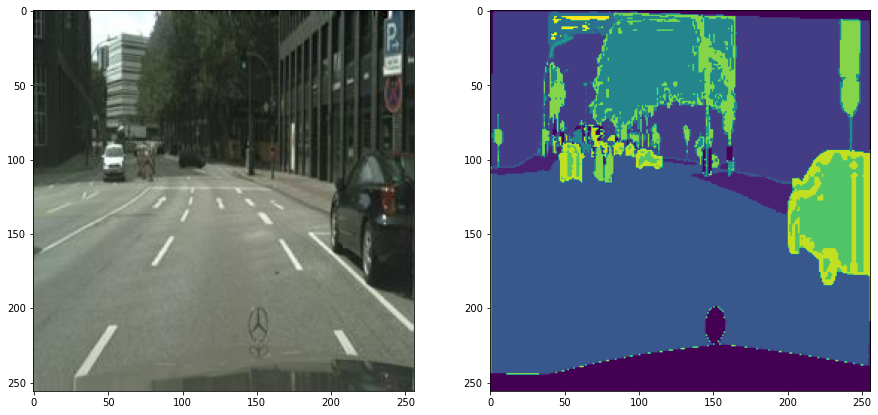

torch.Size([3, 256, 256]) torch.Size([256, 256])
tensor(1.) tensor(0.)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


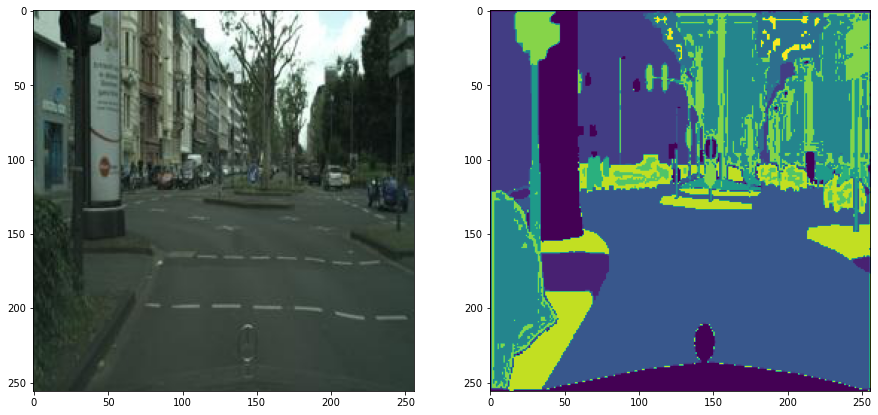

torch.Size([3, 256, 256]) torch.Size([256, 256])
tensor(1.) tensor(0.)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


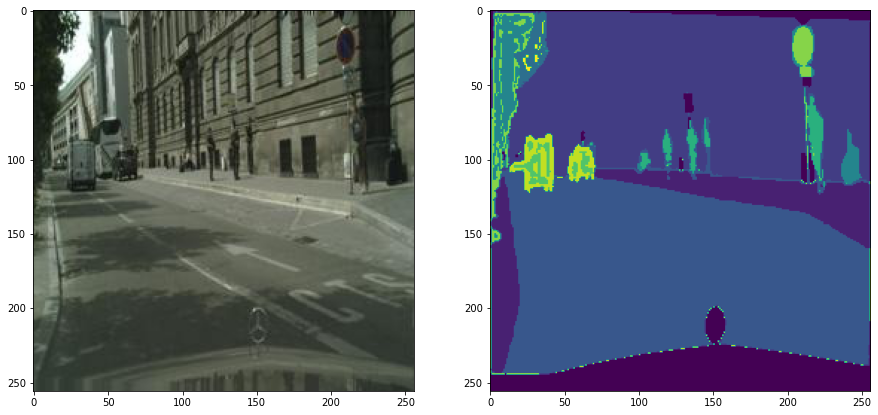

torch.Size([3, 256, 256]) torch.Size([256, 256])
tensor(1.) tensor(0.)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


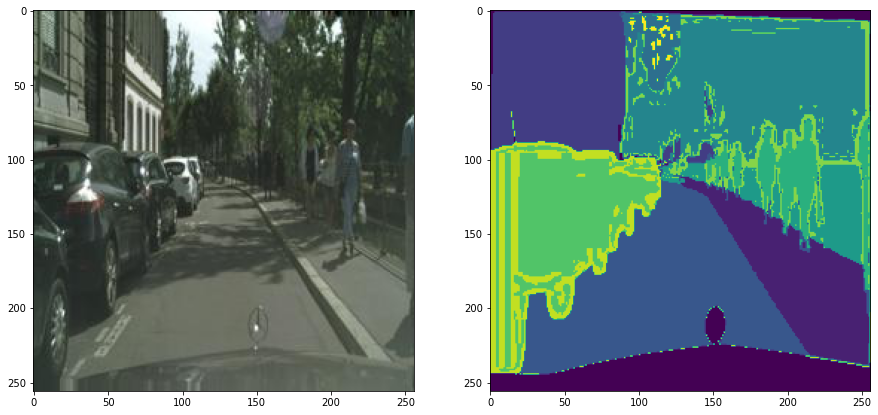

torch.Size([3, 256, 256]) torch.Size([256, 256])
tensor(1.) tensor(0.)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


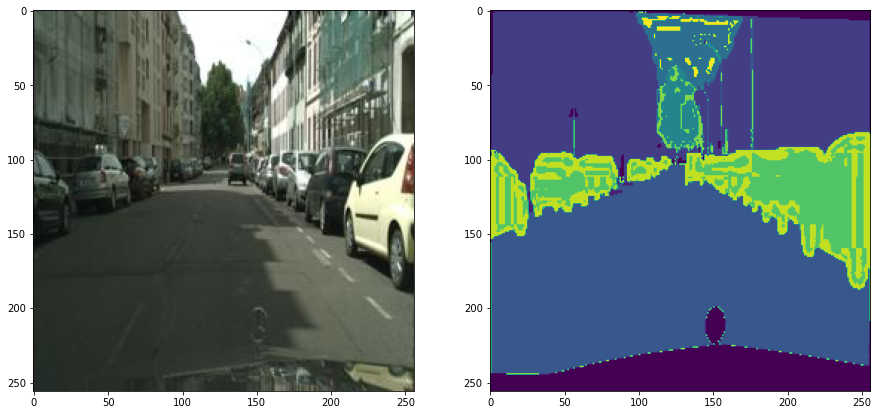

In [17]:
for i in range(5):
    img,  msk = train_data_obj.__getitem__(i)
    print(img.shape, msk.shape)
    print(img.max(), img.min())
    print(msk.max(), msk.min())
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(msk)
    plt.show()

## Define models

In [18]:
unet = UNet(num_classes=OUTPUT_CLASSES)

In [19]:
unet_tune = UNetTunable(in_channels=3,
                        n_classes=OUTPUT_CLASSES,
                        depth=5,
                        wf=6,
                        padding=True,
                        batch_norm=True,
                        up_mode='upconv',
                        conv_mode='dilated'
                       )

## No of trainable parameters

In [20]:
print(sum(p.numel() for p in unet.parameters()))
print(sum(p.numel() for p in unet_tune.parameters()))

34531980
31044236


## Define loss function

In [21]:
model = unet
loss_function = nn.CrossEntropyLoss()

## Define trainer object

In [22]:
trainer =  Trainer(model = model, 
                  crit = loss_function, 
                  train_data = train_data_obj, 
                  val_data = val_data_obj,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE 
                 )

## Start training

--------------------
Validation results after 1 epochs:


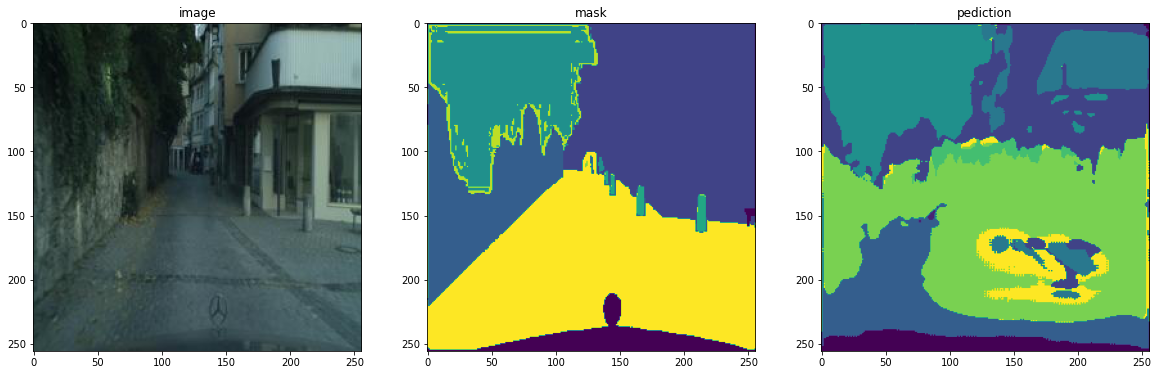

[Epochs-1/10]:
[Train_loss:1.2437 | Train_acc:0.2379 | Val_loss:1.2126 | Val_acc:0.2433]
--------------------
Validation results after 2 epochs:


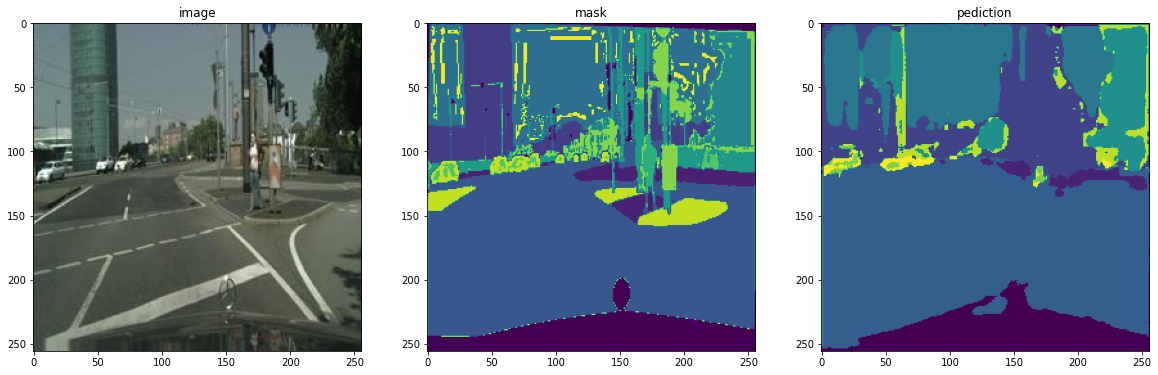

[Epochs-2/10]:
[Train_loss:0.9395 | Train_acc:0.3272 | Val_loss:0.8942 | Val_acc:0.3380]
--------------------
Validation results after 3 epochs:


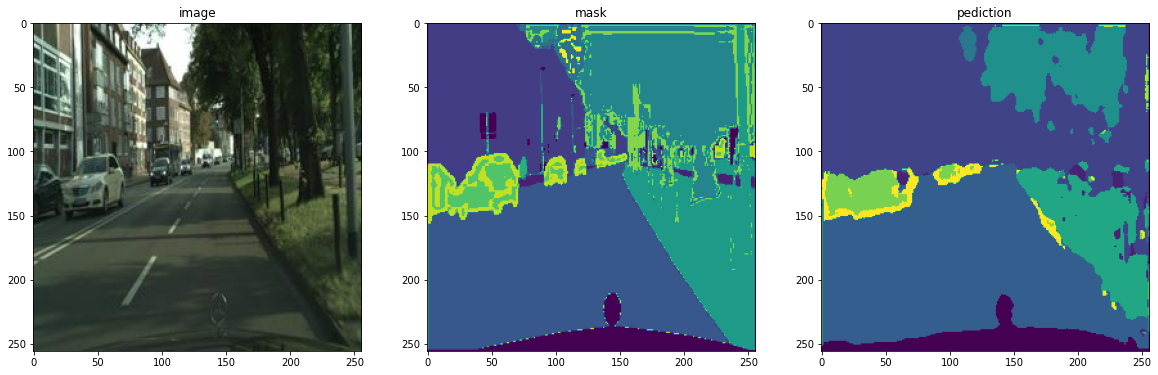

[Epochs-3/10]:
[Train_loss:0.8417 | Train_acc:0.3685 | Val_loss:1.1435 | Val_acc:0.2794]
--------------------
Validation results after 4 epochs:


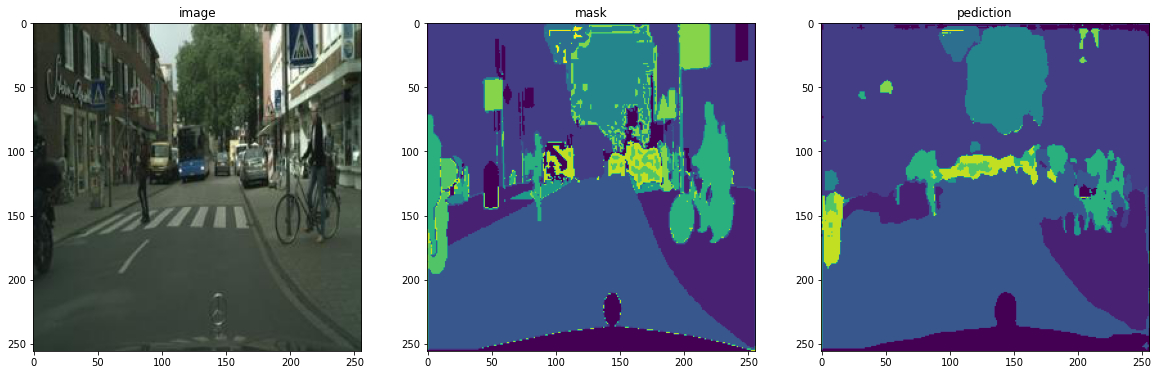

[Epochs-4/10]:
[Train_loss:0.7684 | Train_acc:0.4009 | Val_loss:0.8324 | Val_acc:0.3829]
--------------------
Validation results after 5 epochs:


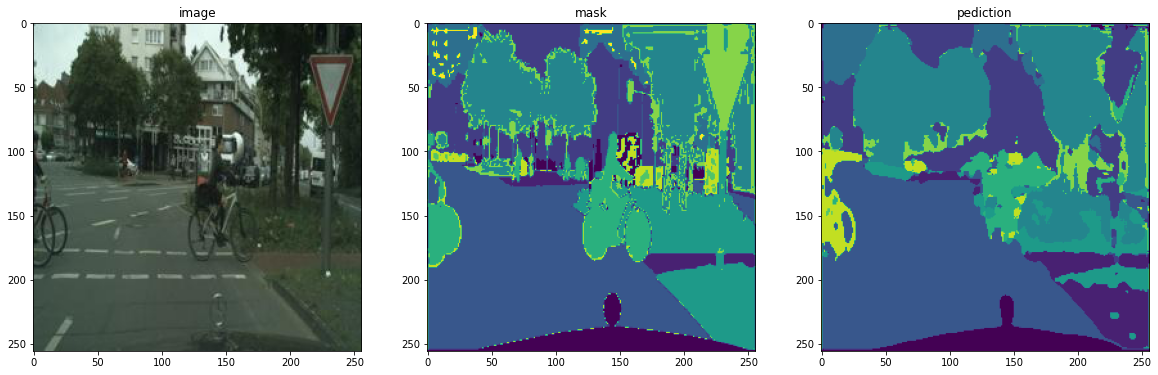

[Epochs-5/10]:
[Train_loss:0.6781 | Train_acc:0.4442 | Val_loss:0.6874 | Val_acc:0.4360]
--------------------
Validation results after 6 epochs:


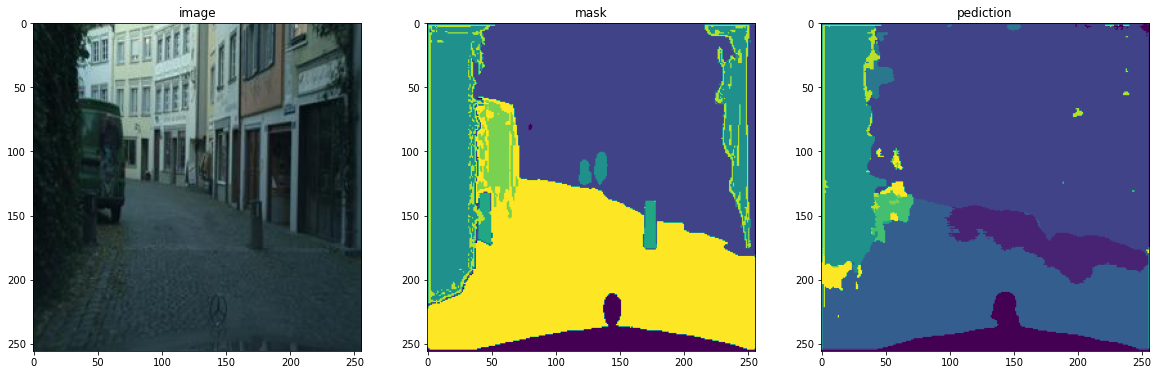

[Epochs-6/10]:
[Train_loss:0.6562 | Train_acc:0.4543 | Val_loss:0.6711 | Val_acc:0.4493]
--------------------
Validation results after 7 epochs:


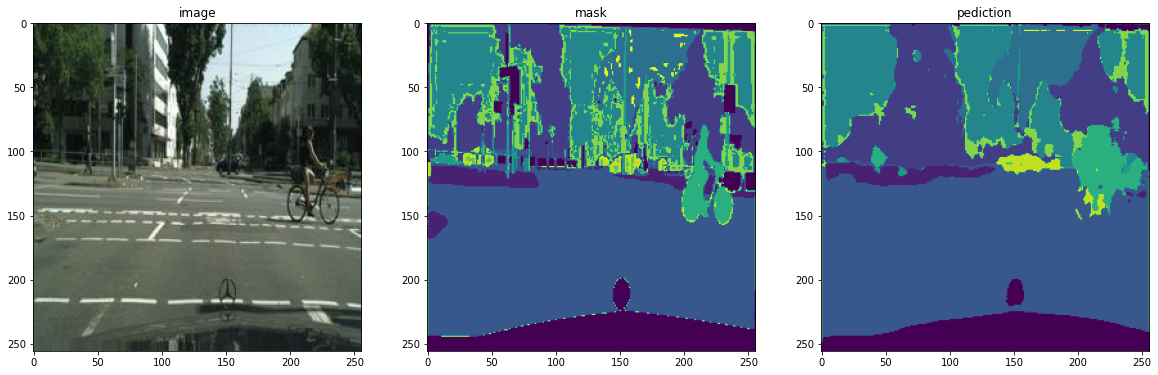

[Epochs-7/10]:
[Train_loss:0.6441 | Train_acc:0.4613 | Val_loss:0.6673 | Val_acc:0.4546]
--------------------
Validation results after 8 epochs:


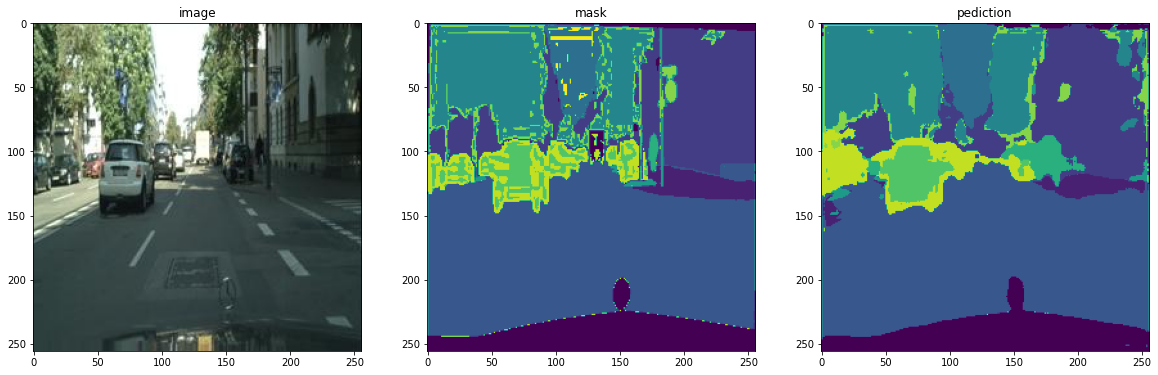

[Epochs-8/10]:
[Train_loss:0.6312 | Train_acc:0.4694 | Val_loss:0.6581 | Val_acc:0.4549]
--------------------
Validation results after 9 epochs:


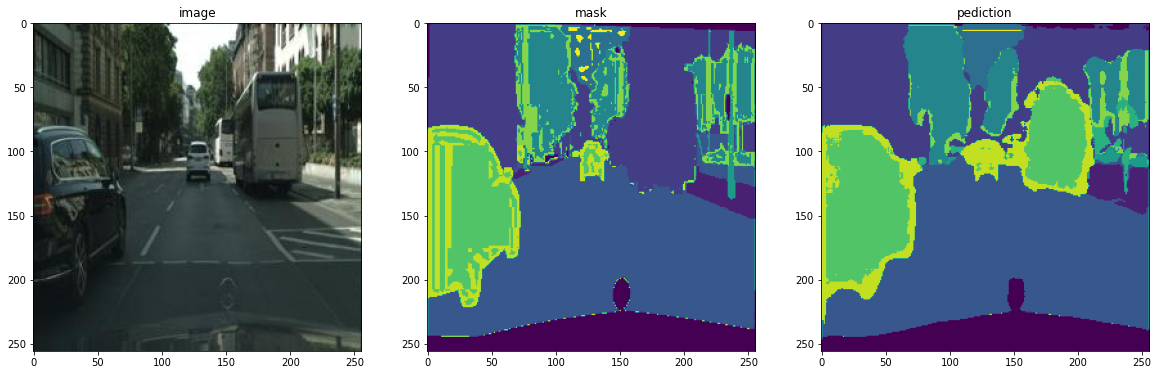

[Epochs-9/10]:
[Train_loss:0.6091 | Train_acc:0.4812 | Val_loss:0.6387 | Val_acc:0.4616]
--------------------
Validation results after 10 epochs:


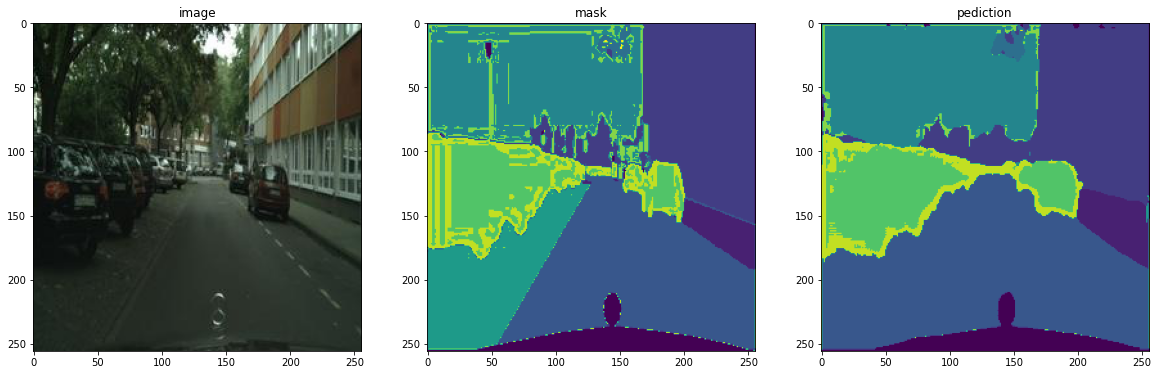

[Epochs-10/10]:
[Train_loss:0.6054 | Train_acc:0.4831 | Val_loss:0.6408 | Val_acc:0.4636]


In [23]:
trainer.train()